In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import notebook
from statistics import NormalDist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from typing import List
from yellowbrick.cluster import KElbowVisualizer
import statsmodels.stats.weightstats as ws
import pytz
import datetime
import math
import retentioneering

### Data Preprocessing

In [2]:
raw_data = pd.read_csv('../resources/test.csv')
# drop full dups
raw_data = raw_data.drop_duplicates()

# take only main mapped events
main_events=['session_start', 'session_end','pass','lost','catalog_page'
             ,'OpenProductPage','main_page','cart_page','search_result_page','AddTo_Cart']
raw_data = raw_data[raw_data['mapped_event'].isin(main_events)]

# fill the nan for future processing
raw_data[['utm_medium', 'utm_source']]=raw_data[['utm_medium', 'utm_source']].fillna('#')

In [3]:
# take only events w/o attributes
cjm = raw_data[['event_timestamp', 'user_id', 'session', 'mapped_event']].drop_duplicates()


# fill the gaps in session for lost/session_end events
cjm['session'] = cjm['session'].combine_first(cjm.groupby('user_id').session.shift(1))
cjm['session'] = cjm['session'].combine_first(cjm.groupby('user_id').session.shift(1))
cjm_df = cjm[~cjm.session.isna()]

In [4]:
def conversion_flg(df, event):
    '''
    Finds if the session was successfully converted to the target state
    '''
    _flow = df.groupby('session')['mapped_event'].apply(list)
    conversion = {}
    for s in _flow.index:
        if event in _flow[s]:
            conversion[s] = 1
        else:
            conversion[s] = 0
    return conversion

pass_dict = conversion_flg(cjm_df, 'pass')
to_card_dict = conversion_flg(cjm_df, 'AddTo_Cart')

cjm_df['pass_flg'] = cjm_df.apply(lambda x: pass_dict[x['session']], axis=1) 
cjm_df['to_cart_flg'] = cjm_df.apply(lambda x: to_card_dict[x['session']], axis=1) 

In [5]:
# check for the session length distr. - this will be a key for the sequence of events in clustering
session_length = cjm_df.\
groupby('session').\
agg({'event_timestamp':'nunique'}).\
reset_index().\
rename(columns={'event_timestamp':'session_length'})

cjm_df = pd.merge(cjm_df, session_length, on = 'session')

[Text(0.5, 1.0, '90% of sessions have 2-10 events')]

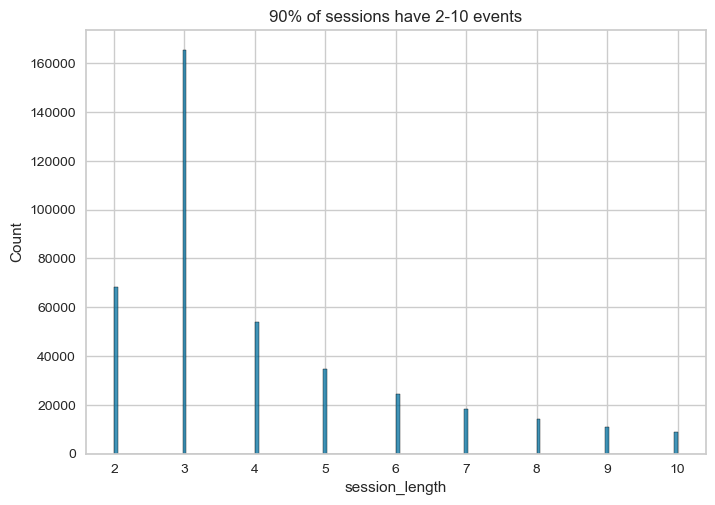

In [6]:
q_l = np.quantile(session_length['session_length'].values, 0.0)
q_r = np.quantile(session_length['session_length'].values, 0.9)
length = session_length[(session_length['session_length'] > q_l) & (session_length['session_length'] < q_r)].session_length

sns.histplot(length).set(title=f'90% of sessions have {int(np.min(length))}-{int(np.max(length))} events')

### Clustering (STUCKED HERE)

In [7]:
retentioneering.config.update({
    'user_col': 'user_id',
    'event_col':'mapped_event',
    'event_time_col':'event_timestamp',
})

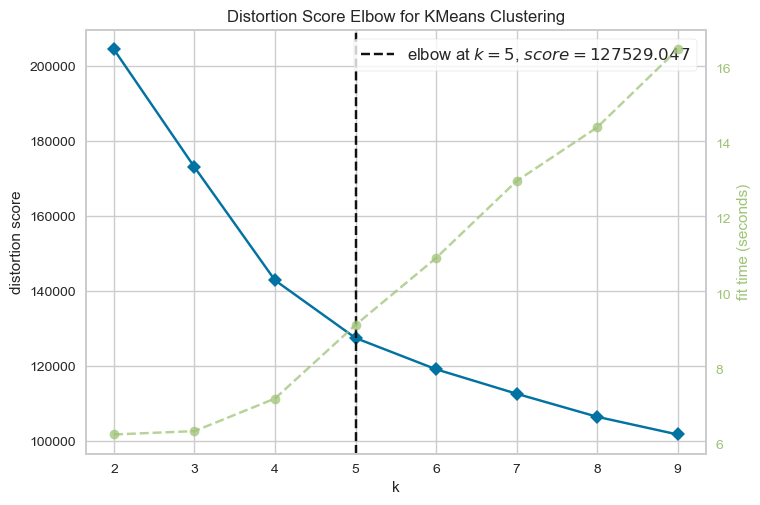

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
# find the optimal n_clusters 
clusterer = KMeans(random_state=42)
visualizer = KElbowVisualizer(clusterer, k=(2,10))
visualizer.fit(cjm_df.rete.extract_features(ngram_range=(2,3)))
visualizer.show()

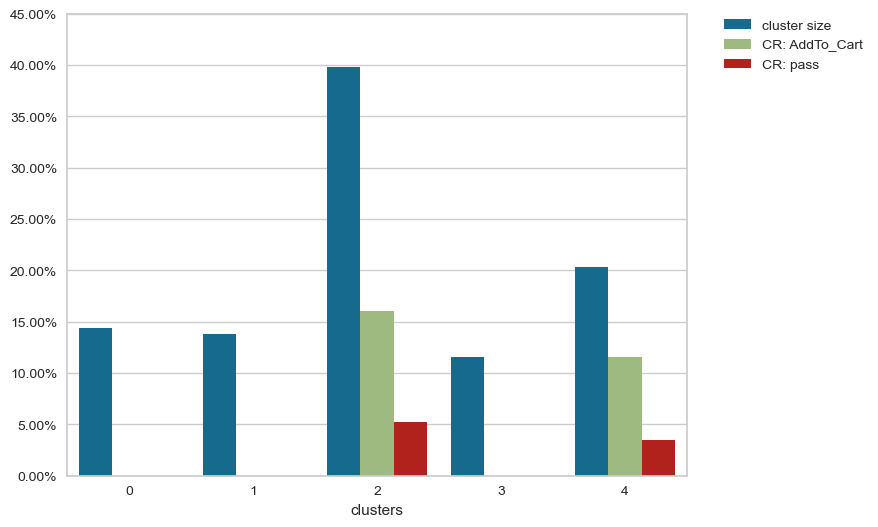

In [9]:
cjm_df.rete.get_clusters(method='kmeans',
                     n_clusters=5,
                     random_state=23,
                     ngram_range=(2,3),
                     plot_type='cluster_bar',
                     targets=['AddTo_Cart','pass']);

There are "dead" clusters 0, 1, 3 with no conversion

wtf, why 2 and 4 so noisy?!

In [13]:
cjm_df.rete.filter_cluster(2).rete.plot_graph(thresh=0.04,
                        norm_type='full',
                        weight_col='user_id',
                        targets = {'lost':'red',
                                   'pass':'green'})

'experiments/graph_2023-01-26 11_24_13_490758.html'

In [15]:
cjm_df.rete.filter_cluster(4).rete.plot_graph(thresh=0.02,
                        norm_type='full',
                        weight_col='user_id',
                        targets = {'lost':'red',
                                   'pass':'green'})

'experiments/graph_2023-01-26 11_25_10_634220.html'

try to dig clusters 2 and 4

In [18]:
clus2 = cjm_df.rete.filter_cluster(2)
clus4 = cjm_df.rete.filter_cluster(4)

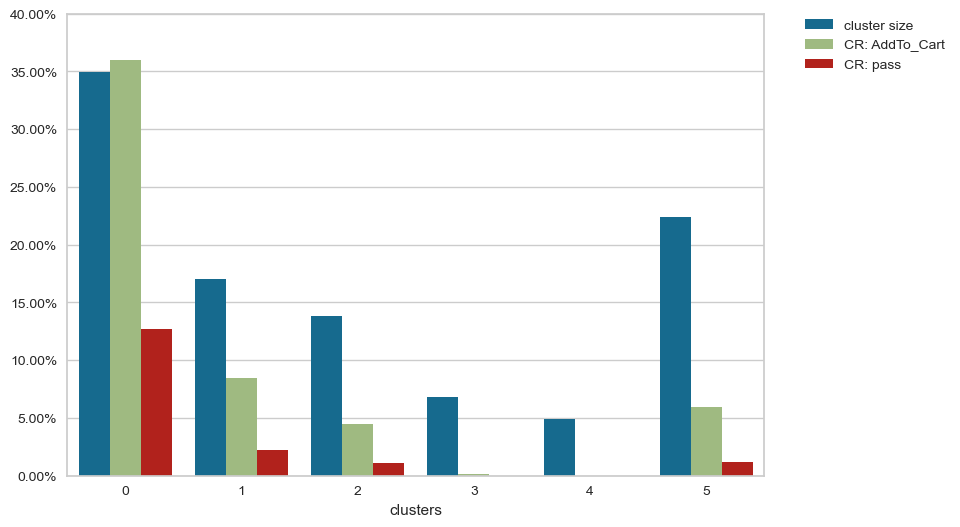

In [19]:
clus2.rete.get_clusters(method='kmeans',
                     n_clusters=6,
                     random_state=23,
                     ngram_range=(2,3),
                     plot_type='cluster_bar',
                     targets=['AddTo_Cart','pass']);

In [20]:
clus2.rete.filter_cluster(0).rete.plot_graph(thresh=0.10,
                        norm_type='full',
                        weight_col='user_id',
                        targets = {'lost':'red',
                                   'pass':'green'})

'experiments/graph_2023-01-26 11_29_33_137324.html'

Have biggest conversion. Looks like casual users:

- session_start
- main_page
- catalog_page
- OpenProductPage
- AddTo_Cart
- card_page
- pass

In [21]:
clus2.rete.filter_cluster(5).rete.plot_graph(thresh=0.01,
                        norm_type='full',
                        weight_col='user_id',
                        targets = {'lost':'red',
                                   'pass':'green'})

'experiments/graph_2023-01-26 11_29_49_019897.html'

Looks like users, how just surf the catalog/product pages. Have low conversion
- session_start
- catalog_page
- OpenProductPage
- AddTo_Card
- cart_page
- pass

In [22]:
clus2.rete.filter_cluster(1).rete.plot_graph(thresh=0.02,
                        norm_type='full',
                        weight_col='user_id',
                        targets = {'lost':'red',
                                   'pass':'green'})

'experiments/graph_2023-01-26 11_30_07_512750.html'

In [23]:
clus2.rete.filter_cluster(3).rete.plot_graph(thresh=0.01,
                        norm_type='full',
                        weight_col='user_id',
                        targets = {'lost':'red',
                                   'pass':'green'})

'experiments/graph_2023-01-26 11_30_09_705043.html'

Users starting from exact product page.
- session_start
- OperProductPage
- AddTo_Cart
- cart_page
- pass

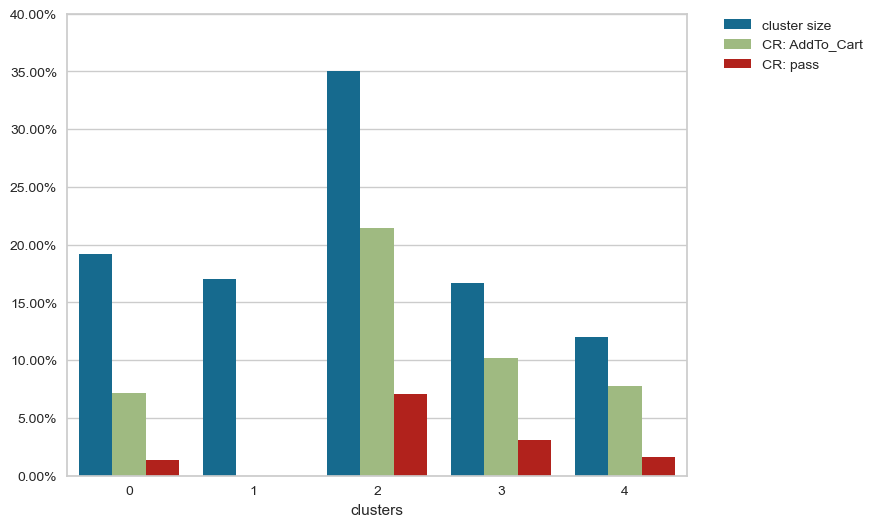

In [24]:
clus4.rete.get_clusters(method='kmeans',
                     n_clusters=5,
                     random_state=23,
                     ngram_range=(2,3),
                     plot_type='cluster_bar',
                     targets=['AddTo_Cart','pass']);

In [25]:
clus4.rete.filter_cluster(2).rete.plot_graph(thresh=0.01,
                        norm_type='full',
                        weight_col='user_id',
                        targets = {'lost':'red',
                                   'pass':'green'})

'experiments/graph_2023-01-26 11_36_00_103985.html'

### Data Mining (USELESS)

In [26]:
# split current_page to the N levels
def splitter(row, level=1):
    '''
   Extracts path component
    '''
    splitted_path = []
    if row['current_path'] is np.NaN:
        pass
    else:
        splitted_path = row['current_path'].split('/')[1:]
    
    if len(splitted_path) > level:
        return splitted_path[level]
    else:
        return None

levels = [0,1,2,3,4,5] # add levels if u want to
for l in notebook.tqdm(levels):
    raw_data[f'path{l}'] = raw_data.apply(splitter, level=l, axis=1)

  0%|          | 0/6 [00:00<?, ?it/s]

In [27]:
feature_prep=raw_data.\
groupby(['user_id']).\
agg({'browser':lambda x: np.unique(x)
    ,'session':'nunique'
    ,'os':lambda x: np.unique(x)
    ,'path0':lambda x: list(np.unique([i for i in x if i is not None]))
    ,'path1':lambda x: list(np.unique([i for i in x if i is not None]))
    ,'path2':lambda x: list(np.unique([i for i in x if i is not None]))
    ,'path3':lambda x: list(np.unique([i for i in x if i is not None]))
    ,'path4':lambda x: list(np.unique([i for i in x if i is not None]))
    ,'path5':lambda x: list(np.unique([i for i in x if i is not None]))
    ,'utm_medium':lambda x: list(np.unique([i for i in x if i != '#']))
    ,'utm_source':lambda x: list(np.unique([i for i in x if i != '#']))}).\
reset_index()

In [28]:
feature_prep.head()

,user_id,browser,session,os,path0,path1,path2,path3,path4,path5,utm_medium,utm_source
0,000019de-e3c2-4af0-8e0c-979b0d5b63cd,Chrome,1,Windows,[catalog],[phone],[225],[apple],[iphone-6s-plus],[6s-plus-64gb],[],[]
1,00009a1c-69ad-4bbf-81e0-75dad05075b5,Mobile Safari,1,iOS,[catalog],[other],[10691],[5391503],[],[],[],[]
2,0000ccf4-7a6d-4ec2-837c-0e7c01d92b04,Chrome Mobile,3,Android,[catalog],"[brand, phone, tag]","[225, sale2706, xiaomi]",[],[],[],[email],"[flocktory-trigger, promo]"
3,00010aae-fcc8-457a-847b-3fb5b9867243,Yandex Browser,1,Android,[catalog],[phone],[225],[xiaomi],[xiaomi-mi-10],[],[],[]
4,0001692d-845f-4256-8ca9-2987060dbf1c,Chrome Mobile,1,Android,[catalog],"[audiovideo, notebook, phone, tag]","[1558, 1738, 224, 225, appleiphone11pro]","[5633111, 5633228, 5663081, 5719883, 5751944, ...","[iphone-11, iphone-se-2020]",[],[cpc],[yandex]


### Hypothesis check

1. Prepare feature:

user_id|session_id|event -> user_id| {list of 0 and 1} (session conversion)

2. Do the linearized T-test

In [29]:
d = {}
for k, v in cjm_df.rete.cluster_mapping.items():
    for user in v:
        d[user] = k
        
cjm_df['cluster'] = cjm_df.apply(lambda x: d[x['user_id']], axis=1)

In [30]:
user_log = cjm_df.\
groupby(['cluster', 'user_id']).\
agg({'pass_flg': lambda x: list(x)
    ,'to_cart_flg': lambda x: list(x)}).\
reset_index()

In [31]:
def get_ratio_var(num, denom):
    """
    Delta-method application for estimate the variance of ratio-metric
    """
    cov = np.cov(num, denom, ddof=1)[0, 1]
    var = (
        (np.std(num) ** 2) / (np.mean(denom) ** 2) +
        (np.mean(num) ** 2) / (np.mean(denom) ** 4) * (np.std(denom) ** 2) -
        2 * np.mean(num) / (np.mean(denom) ** 3) * cov
    ) / len(num)
    return var

In [32]:
def ttest_lin(df: pd.DataFrame, metric_col: str, group_col: str, pair: List[List], ci: float) -> pd.DataFrame:
    '''
    Hypothesis check for linearized metric.
    Pvalue will be corrected with Benjamini-Hochberg procedure
    '''
    if metric_col not in df.columns:
        return f'No such column {metric_col}'
    elif group_col not in df.columns:
        return f'No such columns {group_col}'

    res_table = pd.DataFrame()
    for p in pair:
        d = {}
        num0 = df[df[group_col]==p[0]][metric_col].apply(lambda x: sum(x))
        denom0 = df[df[group_col]==p[0]][metric_col].apply(lambda x: len(x))
        num1 = df[df[group_col]==p[1]][metric_col].apply(lambda x: sum(x))
        denom1 = df[df[group_col]==p[1]][metric_col].apply(lambda x: len(x))
        n0 = len(num0)
        n1 = len(num1)
        ratio0 = sum(num0) / sum(denom0)
        ratio1 = sum(num1) / sum(denom1)
        t, pvalue, df_ = ws.ttest_ind(
            (num0-(ratio0)*denom0).values, 
            (num1-(ratio0)*denom1).values, 
            alternative='two-sided', 
            usevar='unequal'
        )
        delta = ratio1 - ratio0
        
        # ci estimation for conversion delta
        se = np.sqrt(get_ratio_var(num0, denom0) + get_ratio_var(num1, denom1))
        delta_per = (ratio1/ratio0-1)*100
        tail = (1 + ci) / 2
        lb = delta - stats.t.ppf(tail, df_)*se 
        ub = delta + stats.t.ppf(tail, df_)*se
        result = pd.DataFrame(
                np.array([p[0], p[1], t, df_, pvalue, ratio0, ratio1, n0, n1, delta, lb, ub]).reshape(1,-1),
                columns=['group0', 'group1', 't_statistic', 'df', 'pvalue', 'mean0', 'mean1', 'sample0', 'sample1', 'diff_mean','lb','ub']
            )
    res_table = pd.concat([res_table, result])
    
    return res_table

In [33]:
def bh_procedure(pvalues, alpha=0.05):
    '''
    Benjamini-Hochberg procedure
    '''
    m = len(pvalues)
    array_alpha = np.arange(1, m+1)
    array_alpha = alpha * array_alpha / m
    sorted_pvalue_indexes = np.argsort(pvalues)
    res = np.zeros(m)
    for idx, pvalue_index in enumerate(sorted_pvalue_indexes):
        pvalue = pvalues[pvalue_index]
        alpha_ = array_alpha[idx]
        if pvalue <= alpha_:
            res[pvalue_index] = 1
        else:
            break
    res = res.astype(int)
    return res

In [34]:
pass_test=ttest_lin(user_log, 'pass_flg', 'cluster', [[2, 4]], 0.95)
pass_test['effect_flg'] = bh_procedure(pass_test['pvalue'])
pass_test

,group0,group1,t_statistic,df,pvalue,mean0,mean1,sample0,sample1,diff_mean,lb,ub,effect_flg
0,2.0,4.0,8.669589,124887.319759,4.387435e-18,0.078375,0.058853,109668.0,56016.0,-0.019522,-0.024902,-0.014142,1


In [35]:
to_card_test = ttest_lin(user_log, 'to_cart_flg', 'cluster', [[2, 4]], 0.95)
to_card_test['effect_flg'] = bh_procedure(to_card_test['pvalue'])
to_card_test

,group0,group1,t_statistic,df,pvalue,mean0,mean1,sample0,sample1,diff_mean,lb,ub,effect_flg
0,2.0,4.0,7.833868,124082.645807,4.768045e-15,0.20122,0.175799,109668.0,56016.0,-0.025421,-0.033173,-0.017668,1
